
# Tutorial: Traj Segmentation 

**The following notebook illustrate the `TrajSegmentation` class.**



* Loading dependencies

In [1]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingConfig
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingResult
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessing

from megabouts.preprocessing.tail_preprocessing import TailPreprocessingConfig
from megabouts.preprocessing.tail_preprocessing import TailPreprocessingResult
from megabouts.preprocessing.tail_preprocessing import TailPreprocessing


from megabouts.segmentation.segmentation_config import TailSegmentationConfig
from megabouts.segmentation.segmentation_config import TrajSegmentationConfig

from megabouts.segmentation.segmentation import TailSegmentation
from megabouts.segmentation.segmentation import TrajSegmentation

from megabouts.segmentation.segmentation import SegmentationFactory
from megabouts.segmentation.segmentation import SegmentationResult

## Loading Data and Preprocessing

* TrackingConfig and TrackingData similar to [tutorial_Tail_Preprocessing](./tutorial_Tail_Preprocessing.ipynb)

In [2]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps,
                                                 num_pcs=4,
                                                 savgol_window_ms=15,
                                                 tail_speed_filter_ms = 100,
                                                 tail_speed_boxcar_filter_ms = 14
                                                 )
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)


traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)
traj_df_input = tracking_data.traj_df
traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

# Segmentation using kinematic vigor

In [3]:
kinematic_vigor = traj.vigor


In [4]:
traj_segmentation_cfg = TrajSegmentationConfig(fps=tracking_cfg.fps,
                                               peak_prominence=0.75,
                                               peak_percentage=0.1
                                               )
segmentation_function = SegmentationFactory.get_segmenter(traj_segmentation_cfg)
segments = segmentation_function.segment_from_traj(kinematic_vigor)


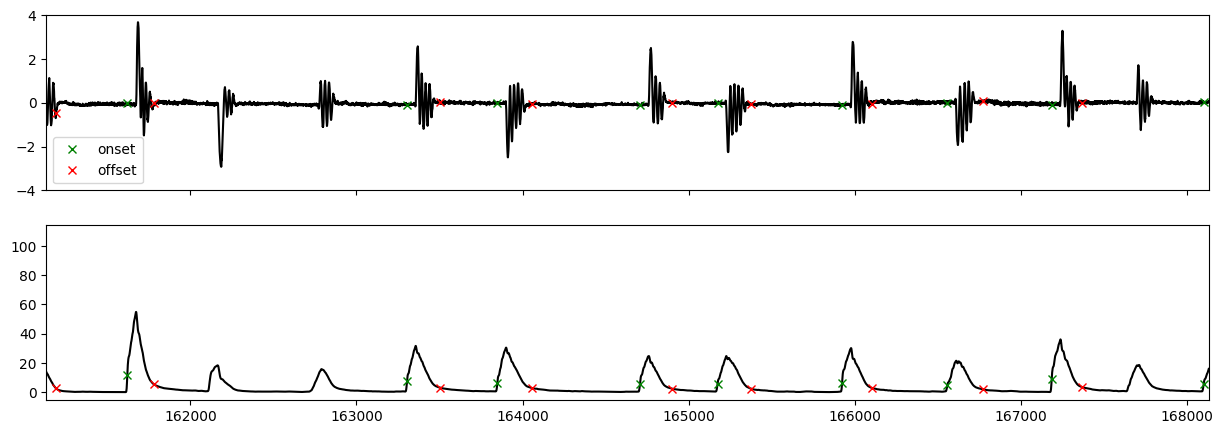

In [9]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x,'k')
ax[0].plot(segments.onset, x[segments.onset], "x",color='green',label='onset')
ax[0].plot(segments.offset, x[segments.offset], "x",color='red',label='offset')
ax[0].set_ylim(-4,4)
ax[0].legend()

x = kinematic_vigor
ax[1].plot(x,'k')
ax[1].plot(segments.onset, x[segments.onset], "x",color='green')
ax[1].plot(segments.offset, x[segments.offset], "x",color='red')

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [6]:
# Number of bouts as function of threshold:
thresh_list = np.linspace(0.1,20,100)
num_peaks = np.zeros_like(thresh_list)
kinematic_vigor = traj.vigor

for i,thresh in enumerate(thresh_list):
    traj_segmentation_cfg = TrajSegmentationConfig(fps=tracking_cfg.fps,
                                                   peak_prominence=thresh,
                                                   peak_percentage=0.1)
    segmentation_function = SegmentationFactory.get_segmenter(traj_segmentation_cfg)
    segments = segmentation_function.segment_from_traj(kinematic_vigor)

    num_peaks[i] = len(segments.onset)


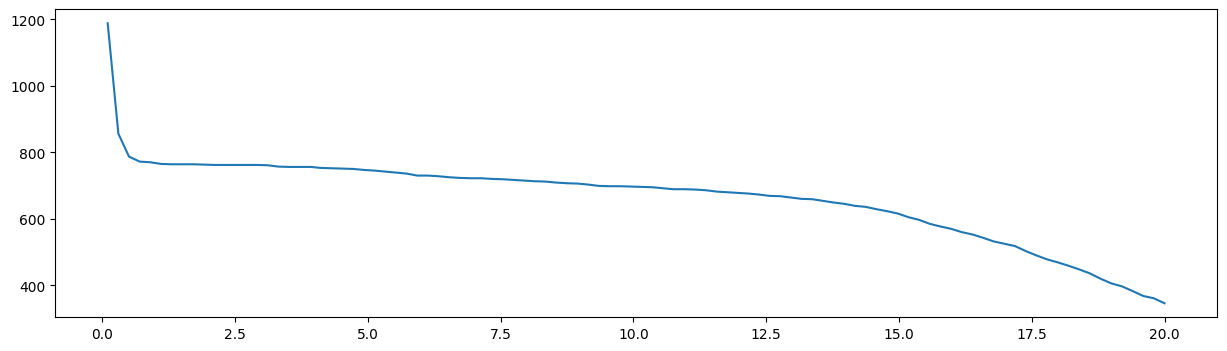

In [7]:
plt.figure(figsize=(15,4))
plt.plot(thresh_list,num_peaks)
plt.show()